# Import libraries and read S&P500 data

In [67]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [68]:
spy_data = pd.read_csv('spy.csv')
spy_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1,1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
2,1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
3,1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
4,1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000
...,...,...,...,...,...,...,...
8434,2023-06-26,4344.839844,4362.060059,4328.080078,4328.819824,4328.819824,3415030000
8435,2023-06-27,4337.359863,4384.419922,4335.000000,4378.410156,4378.410156,3573500000
8436,2023-06-28,4367.479980,4390.350098,4360.220215,4376.859863,4376.859863,3739330000
8437,2023-06-29,4374.939941,4398.390137,4371.970215,4396.439941,4396.439941,3696660000


In [69]:
spy_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)


In [70]:
spy_data.dtypes

Date      object
Close    float64
dtype: object

In [71]:
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [72]:
spy_data.dropna(inplace=True)
spy_data

,Date,Close
0,1990-01-02,359.690002
1,1990-01-03,358.760010
2,1990-01-04,355.670013
3,1990-01-05,352.200012
4,1990-01-08,353.790009
...,...,...
8434,2023-06-26,4328.819824
8435,2023-06-27,4378.410156
8436,2023-06-28,4376.859863
8437,2023-06-29,4396.439941


In [73]:
spy_data = spy_data[spy_data['Date'].dt.year >= 1992]

In [74]:
spy_data

,Date,Close
506,1992-01-02,417.260010
507,1992-01-03,419.339996
508,1992-01-06,417.959991
509,1992-01-07,417.399994
510,1992-01-08,418.100006
...,...,...
8434,2023-06-26,4328.819824
8435,2023-06-27,4378.410156
8436,2023-06-28,4376.859863
8437,2023-06-29,4396.439941


# Importing economic indicators and preparing it for use for analysis

## 1.) Import unemployment rate
Data is available from 1948, however I will discard data before 1992. 
Unemployment rate is updated each month.

In [75]:
unemployment_rate = pd.read_csv('unemp_data.csv')
unemployment_rate.dropna()
unemployment_rate


,Date,unemp_rate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
900,2023-01-01,3.4
901,2023-02-01,3.6
902,2023-03-01,3.5
903,2023-04-01,3.4


In [76]:
unemployment_rate['Date'] = pd.to_datetime(unemployment_rate['Date'])
unemployment_rate.dtypes

Date          datetime64[ns]
unemp_rate           float64
dtype: object

In [77]:
unemployment_rate = unemployment_rate[unemployment_rate['Date'].dt.year >= 1992]
unemployment_rate

,Date,unemp_rate
528,1992-01-01,7.3
529,1992-02-01,7.4
530,1992-03-01,7.4
531,1992-04-01,7.4
532,1992-05-01,7.6
...,...,...
900,2023-01-01,3.4
901,2023-02-01,3.6
902,2023-03-01,3.5
903,2023-04-01,3.4


In [78]:
## The below method for forward fill will be use on other indicators which are not updated daily ##
# Set the 'Date' column as the index of the 'unemployment_rate' DataFrame
unemployment_rate.set_index('Date', inplace=True)

# Resample the data from monthly to daily frequency and forward fill the missing values
unemp_rate_daily = unemployment_rate['unemp_rate'].asfreq('D', method='ffill')

# Reset the index to include the date column again
unemp_rate_daily = unemp_rate_daily.reset_index()

# Find the last date in the 'spy_data' DataFrame
last_date_spy = spy_data['Date'].max()

# Filter the 'unemp_rate_daily' DataFrame up to the last date in 'spy_data'
unemp_rate_daily = unemp_rate_daily[unemp_rate_daily['Date'] <= last_date_spy]

# Create a date range from the day after the last date in 'unemp_rate_daily' until the last date in 'spy_data'
date_range = pd.date_range(start=unemp_rate_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

# Create a DataFrame with the date range and fill the 'unemp_rate' column with NaN
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['unemp_rate'] = np.nan

# Concatenate the 'unemp_rate_daily' DataFrame with the forward fill DataFrame
unemp_rate_daily = pd.concat([unemp_rate_daily, forward_fill_df])

# Forward fill the missing values
unemp_rate_daily['unemp_rate'].fillna(method='ffill', inplace=True)

# Print the extrapolated 'unemp_rate_daily' DataFrame
print(unemp_rate_daily)


         Date  unemp_rate
0  1992-01-01         7.3
1  1992-01-02         7.3
2  1992-01-03         7.3
3  1992-01-04         7.3
4  1992-01-05         7.3
..        ...         ...
55 2023-06-26         3.7
56 2023-06-27         3.7
57 2023-06-28         3.7
58 2023-06-29         3.7
59 2023-06-30         3.7

[11504 rows x 2 columns]


In [79]:
unemp_rate_daily[unemp_rate_daily.duplicated()]

,Date,unemp_rate


## 2.) Import AAA vs treasury yield
This measures the spread between Moody's Seasoned Aaa Corporate Bond© (https://fred.stlouisfed.org/series/DAAA) and 10-Year Treasury Constant Maturity (BC_10YEARM).

It has daily values, which will be converted to monthly values by averaging all the values for each month.

In [80]:
aaavstreasury = pd.read_csv('aaavstreasury.csv')
aaavstreasury.dropna()
aaavstreasury.dtypes

Date              object
aaaVsTreasury    float64
dtype: object

In [81]:
aaavstreasury['Date'] = pd.to_datetime(aaavstreasury['Date'])
aaavstreasury.dtypes

Date             datetime64[ns]
aaaVsTreasury           float64
dtype: object

In [82]:
aaavstreasury


,Date,aaaVsTreasury
0,1983-01-03,1.45
1,1983-01-04,1.42
2,1983-01-05,1.44
3,1983-01-06,1.35
4,1983-01-07,1.38
...,...,...
10116,2023-06-22,0.84
10117,2023-06-23,0.86
10118,2023-06-26,0.88
10119,2023-06-27,0.85


In [83]:
aaavstreasury =aaavstreasury[aaavstreasury['Date'].dt.year >= 1992]

In [84]:
aaavstreasury[aaavstreasury.duplicated()]

,Date,aaaVsTreasury


## 3.) CPI


In [85]:
cpi = pd.read_csv('cpi_data.csv')
cpi.dropna()
cpi.dtypes

Date     object
cpi     float64
dtype: object

In [86]:
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi.dtypes

Date    datetime64[ns]
cpi            float64
dtype: object

In [87]:
cpi

,Date,cpi
0,1947-01-01,21.480
1,1947-02-01,21.620
2,1947-03-01,22.000
3,1947-04-01,22.000
4,1947-05-01,21.950
...,...,...
912,2023-01-01,300.536
913,2023-02-01,301.648
914,2023-03-01,301.808
915,2023-04-01,302.918


In [88]:
cpi = cpi[cpi['Date'].dt.year >= 1992]

In [89]:

cpi.set_index('Date', inplace=True)
cpi_daily = cpi['cpi'].asfreq('D', method='ffill')
cpi_daily = cpi_daily.reset_index()
print(cpi_daily)



            Date      cpi
0     1992-01-01  138.300
1     1992-01-02  138.300
2     1992-01-03  138.300
3     1992-01-04  138.300
4     1992-01-05  138.300
...          ...      ...
11439 2023-04-27  302.918
11440 2023-04-28  302.918
11441 2023-04-29  302.918
11442 2023-04-30  302.918
11443 2023-05-01  303.294

[11444 rows x 2 columns]


In [90]:
last_date_spy = spy_data['Date'].max()

cpi_daily = cpi_daily[cpi_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=cpi_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['cpi'] = np.nan


cpi_daily = pd.concat([cpi_daily, forward_fill_df])
cpi_daily['cpi'].fillna(method='ffill', inplace=True)
cpi_daily


,Date,cpi
0,1992-01-01,138.300
1,1992-01-02,138.300
2,1992-01-03,138.300
3,1992-01-04,138.300
4,1992-01-05,138.300
...,...,...
55,2023-06-26,303.294
56,2023-06-27,303.294
57,2023-06-28,303.294
58,2023-06-29,303.294


In [91]:
cpi_daily[cpi_daily.duplicated()]

,Date,cpi


## 4.) GDP data

In [92]:
gdp = pd.read_csv('gdp_data.csv')
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp.dropna()
gdp.dtypes

Date    datetime64[ns]
GDP            float64
dtype: object

In [93]:
gdp

,Date,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
300,2022-01-01,24740.480
301,2022-04-01,25248.476
302,2022-07-01,25723.941
303,2022-10-01,26137.992


In [94]:
gdp = gdp[gdp['Date'].dt.year >= 1992]
gdp

,Date,GDP
180,1992-01-01,6363.102
181,1992-04-01,6470.763
182,1992-07-01,6566.641
183,1992-10-01,6680.803
184,1993-01-01,6729.459
...,...,...
300,2022-01-01,24740.480
301,2022-04-01,25248.476
302,2022-07-01,25723.941
303,2022-10-01,26137.992


In [95]:
gdp.set_index('Date', inplace=True)
gdp_daily = gdp['GDP'].asfreq('D', method='ffill')
gdp_daily = gdp_daily.reset_index()
print(gdp_daily)


            Date        GDP
0     1992-01-01   6363.102
1     1992-01-02   6363.102
2     1992-01-03   6363.102
3     1992-01-04   6363.102
4     1992-01-05   6363.102
...          ...        ...
11319 2022-12-28  26137.992
11320 2022-12-29  26137.992
11321 2022-12-30  26137.992
11322 2022-12-31  26137.992
11323 2023-01-01  26529.774

[11324 rows x 2 columns]


In [96]:
last_date_spy = spy_data['Date'].max()

gdp_daily = gdp_daily[gdp_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=gdp_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['GDP'] = np.nan

gdp_daily = pd.concat([gdp_daily, forward_fill_df])

gdp_daily['GDP'].fillna(method='ffill', inplace=True)
gdp_daily


,Date,GDP
0,1992-01-01,6363.102
1,1992-01-02,6363.102
2,1992-01-03,6363.102
3,1992-01-04,6363.102
4,1992-01-05,6363.102
...,...,...
175,2023-06-26,26529.774
176,2023-06-27,26529.774
177,2023-06-28,26529.774
178,2023-06-29,26529.774


In [97]:
gdp_daily[gdp_daily.duplicated()]

,Date,GDP


## 5.) MNO data

In [98]:
mno = pd.read_csv('mno_data.csv')
mno['Date'] = pd.to_datetime(mno['Date'])
mno.dropna()
mno

,Date,manuNewOrders
0,1992-02-01,223500.0
1,1992-03-01,233732.0
2,1992-04-01,238173.0
3,1992-05-01,241916.0
4,1992-06-01,240660.0
...,...,...
370,2022-12-01,580918.0
371,2023-01-01,581049.0
372,2023-02-01,571265.0
373,2023-03-01,574915.0


In [99]:
mno.set_index('Date', inplace=True)
mno_daily = mno['manuNewOrders'].asfreq('D', method='ffill')
mno_daily = mno_daily.reset_index()
print(mno_daily)


            Date  manuNewOrders
0     1992-02-01       223500.0
1     1992-02-02       223500.0
2     1992-02-03       223500.0
3     1992-02-04       223500.0
4     1992-02-05       223500.0
...          ...            ...
11378 2023-03-28       574915.0
11379 2023-03-29       574915.0
11380 2023-03-30       574915.0
11381 2023-03-31       574915.0
11382 2023-04-01       577496.0

[11383 rows x 2 columns]


In [100]:
# Find the last date in the 'spy_data' DataFrame
last_date_spy = spy_data['Date'].max()

mno_daily = mno_daily[mno_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=mno_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['manuNewOrders'] = np.nan
mno_daily = pd.concat([mno_daily, forward_fill_df])
mno_daily['manuNewOrders'].fillna(method='ffill', inplace=True)

mno_daily


,Date,manuNewOrders
0,1992-02-01,223500.0
1,1992-02-02,223500.0
2,1992-02-03,223500.0
3,1992-02-04,223500.0
4,1992-02-05,223500.0
...,...,...
85,2023-06-26,577496.0
86,2023-06-27,577496.0
87,2023-06-28,577496.0
88,2023-06-29,577496.0


In [101]:
mno_daily[mno_daily.duplicated()]

,Date,manuNewOrders


## 6.) Oil prices

In [102]:
oil_prices = pd.read_csv('oil_prices.csv')
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
oil_prices.dropna()
oil_prices

,Date,oilPrice
0,1990-01-01,22.604348
1,1990-02-01,22.202500
2,1990-03-01,20.440455
3,1990-04-01,18.526667
4,1990-05-01,18.443043
...,...,...
396,2023-01-01,78.251364
397,2023-02-01,77.027500
398,2023-03-01,73.348261
399,2023-04-01,79.126500


In [103]:
oil_prices = oil_prices[oil_prices['Date'].dt.year >=1992]

In [104]:
oil_prices.set_index('Date', inplace=True)
oil_prices_daily = oil_prices['oilPrice'].asfreq('D', method='ffill')
oil_prices_daily = oil_prices_daily.reset_index()
print(oil_prices_daily)


            Date   oilPrice
0     1992-01-01  18.806957
1     1992-01-02  18.806957
2     1992-01-03  18.806957
3     1992-01-04  18.806957
4     1992-01-05  18.806957
...          ...        ...
11439 2023-04-27  79.126500
11440 2023-04-28  79.126500
11441 2023-04-29  79.126500
11442 2023-04-30  79.126500
11443 2023-05-01  71.673478

[11444 rows x 2 columns]


In [105]:
last_date_spy = spy_data['Date'].max()
oil_prices_daily = oil_prices_daily[oil_prices_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=oil_prices_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['oilPrice'] = np.nan

oil_prices_daily = pd.concat([oil_prices_daily, forward_fill_df])

oil_prices_daily['oilPrice'].fillna(method='ffill', inplace=True)
oil_prices_daily


,Date,oilPrice
0,1992-01-01,18.806957
1,1992-01-02,18.806957
2,1992-01-03,18.806957
3,1992-01-04,18.806957
4,1992-01-05,18.806957
...,...,...
55,2023-06-26,71.673478
56,2023-06-27,71.673478
57,2023-06-28,71.673478
58,2023-06-29,71.673478


In [106]:
oil_prices_daily[oil_prices_daily.duplicated()]

,Date,oilPrice


## 7.) Consumer confidence

In [107]:
consumer_confidence_sent = pd.read_csv('consumer_confidence_sent.csv')
consumer_confidence_sent['Date'] = pd.to_datetime(consumer_confidence_sent['Date'])
consumer_confidence_sent.dropna()
consumer_confidence_sent

,Date,senti
0,1960-01-01,101.641974
1,1960-02-01,101.379140
2,1960-03-01,101.152075
3,1960-04-01,101.026822
4,1960-05-01,101.058444
...,...,...
756,2023-01-01,97.303185
757,2023-02-01,97.442955
758,2023-03-01,97.332214
759,2023-04-01,97.155482


In [108]:
consumer_confidence_sent = consumer_confidence_sent[consumer_confidence_sent['Date'].dt.year >= 1992]
consumer_confidence_sent

,Date,senti
384,1992-01-01,97.868986
385,1992-02-01,98.118227
386,1992-03-01,98.565418
387,1992-04-01,98.920670
388,1992-05-01,99.122926
...,...,...
756,2023-01-01,97.303185
757,2023-02-01,97.442955
758,2023-03-01,97.332214
759,2023-04-01,97.155482


In [109]:
consumer_confidence_sent.set_index('Date', inplace=True)
consumer_confidence_sent_daily = consumer_confidence_sent['senti'].asfreq('D', method='ffill')
consumer_confidence_sent_daily = consumer_confidence_sent_daily.reset_index()
print(consumer_confidence_sent_daily)


            Date      senti
0     1992-01-01  97.868986
1     1992-01-02  97.868986
2     1992-01-03  97.868986
3     1992-01-04  97.868986
4     1992-01-05  97.868986
...          ...        ...
11439 2023-04-27  97.155482
11440 2023-04-28  97.155482
11441 2023-04-29  97.155482
11442 2023-04-30  97.155482
11443 2023-05-01  96.877280

[11444 rows x 2 columns]


In [110]:
last_date_spy = spy_data['Date'].max()

consumer_confidence_sent_daily = consumer_confidence_sent_daily[consumer_confidence_sent_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=consumer_confidence_sent_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['senti'] = np.nan

consumer_confidence_sent_daily = pd.concat([consumer_confidence_sent_daily, forward_fill_df])

consumer_confidence_sent_daily['senti'].fillna(method='ffill', inplace=True)

consumer_confidence_sent_daily


,Date,senti
0,1992-01-01,97.868986
1,1992-01-02,97.868986
2,1992-01-03,97.868986
3,1992-01-04,97.868986
4,1992-01-05,97.868986
...,...,...
55,2023-06-26,96.877280
56,2023-06-27,96.877280
57,2023-06-28,96.877280
58,2023-06-29,96.877280


In [111]:
consumer_confidence_sent_daily[consumer_confidence_sent_daily.duplicated()]

,Date,senti


## 8.) 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (T10Y3M)

Series is calculated as the spread between 10-Year Treasury Constant Maturity (BC_10YEAR) and 3-Month Treasury Constant Maturity (BC_3MONTH).

In [112]:
t10y3m = pd.read_csv('t10y3m.csv')
t10y3m['Date'] = pd.to_datetime(t10y3m['Date'])
t10y3m.dropna()
t10y3m

,Date,t10y3m
0,1982-01-04,2.32
1,1982-01-05,2.24
2,1982-01-06,2.43
3,1982-01-07,2.46
4,1982-01-08,2.50
...,...,...
10371,2023-06-23,-1.67
10372,2023-06-26,-1.78
10373,2023-06-27,-1.67
10374,2023-06-28,-1.73


In [113]:
t10y3m[t10y3m.duplicated()]

,Date,t10y3m


## 9.) CBOE Volatility Index: VIX (VIXCLS)	
VIX measures market expectation of near term volatility conveyed by stock index option prices

In [114]:
vix = pd.read_csv('vix.csv')
vix['Date'] = pd.to_datetime(vix['Date'])
vix.dropna()
vix

,Date,vix
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26
...,...,...
8440,2023-06-23,13.44
8441,2023-06-26,14.25
8442,2023-06-27,13.74
8443,2023-06-28,13.43


In [115]:
vix = vix[vix['Date'].dt.year >= 1992]
vix

,Date,vix
505,1992-01-02,18.95
506,1992-01-03,18.75
507,1992-01-06,18.96
508,1992-01-07,19.23
509,1992-01-08,18.72
...,...,...
8440,2023-06-23,13.44
8441,2023-06-26,14.25
8442,2023-06-27,13.74
8443,2023-06-28,13.43


In [116]:
vix[vix.duplicated()]

,Date,vix


## 10.) Business Tendency Surveys for Manufacturing: Confidence Indicators

In [117]:
bus_confidence = pd.read_csv('bus_confidence.csv')
bus_confidence['Date'] = pd.to_datetime(bus_confidence['Date'])
bus_confidence.dropna()
bus_confidence

,Date,bus_confidence
0,1960-01-01,100.791957
1,1960-02-01,100.040093
2,1960-03-01,99.063732
3,1960-04-01,98.298624
4,1960-05-01,97.886914
...,...,...
756,2023-01-01,98.986356
757,2023-02-01,98.937179
758,2023-03-01,98.903667
759,2023-04-01,98.906938


In [118]:
bus_confidence = bus_confidence[bus_confidence['Date'].dt.year >= 1992]
bus_confidence

,Date,bus_confidence
384,1992-01-01,99.043552
385,1992-02-01,99.550797
386,1992-03-01,99.971714
387,1992-04-01,100.157188
388,1992-05-01,100.280124
...,...,...
756,2023-01-01,98.986356
757,2023-02-01,98.937179
758,2023-03-01,98.903667
759,2023-04-01,98.906938


In [119]:
bus_confidence.set_index('Date', inplace=True)
bus_confidence_daily = bus_confidence['bus_confidence'].asfreq('D', method='ffill')
bus_confidence_daily = bus_confidence_daily.reset_index()
print(bus_confidence_daily)

            Date  bus_confidence
0     1992-01-01       99.043552
1     1992-01-02       99.043552
2     1992-01-03       99.043552
3     1992-01-04       99.043552
4     1992-01-05       99.043552
...          ...             ...
11439 2023-04-27       98.906938
11440 2023-04-28       98.906938
11441 2023-04-29       98.906938
11442 2023-04-30       98.906938
11443 2023-05-01       98.912986

[11444 rows x 2 columns]


In [120]:
last_date_spy = spy_data['Date'].max()


bus_confidence_daily = bus_confidence_daily[bus_confidence_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=bus_confidence_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')


forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['bus_confidence'] = np.nan
bus_confidence_daily = pd.concat([bus_confidence_daily, forward_fill_df])

bus_confidence_daily['bus_confidence'].fillna(method='ffill', inplace=True)

bus_confidence_daily


,Date,bus_confidence
0,1992-01-01,99.043552
1,1992-01-02,99.043552
2,1992-01-03,99.043552
3,1992-01-04,99.043552
4,1992-01-05,99.043552
...,...,...
55,2023-06-26,98.912986
56,2023-06-27,98.912986
57,2023-06-28,98.912986
58,2023-06-29,98.912986


In [121]:
bus_confidence_daily[bus_confidence_daily.duplicated()]

,Date,bus_confidence


# Pairplot and Correlation matrix of indicators against SPY

In [122]:
spy_data.reset_index(drop=True, inplace=True)
unemp_rate_daily.reset_index(drop=True, inplace=True)
aaavstreasury.reset_index(drop=True, inplace=True)
cpi_daily.reset_index(drop=True, inplace=True)
oil_prices_daily.reset_index(drop=True, inplace=True)
mno_daily.reset_index(drop=True, inplace=True)
gdp_daily.reset_index(drop=True, inplace=True)
bus_confidence_daily.reset_index(drop=True, inplace=True)
vix.reset_index(drop=True, inplace=True)
t10y3m.reset_index(drop=True, inplace=True)
consumer_confidence_sent_daily.reset_index(drop=True, inplace=True)


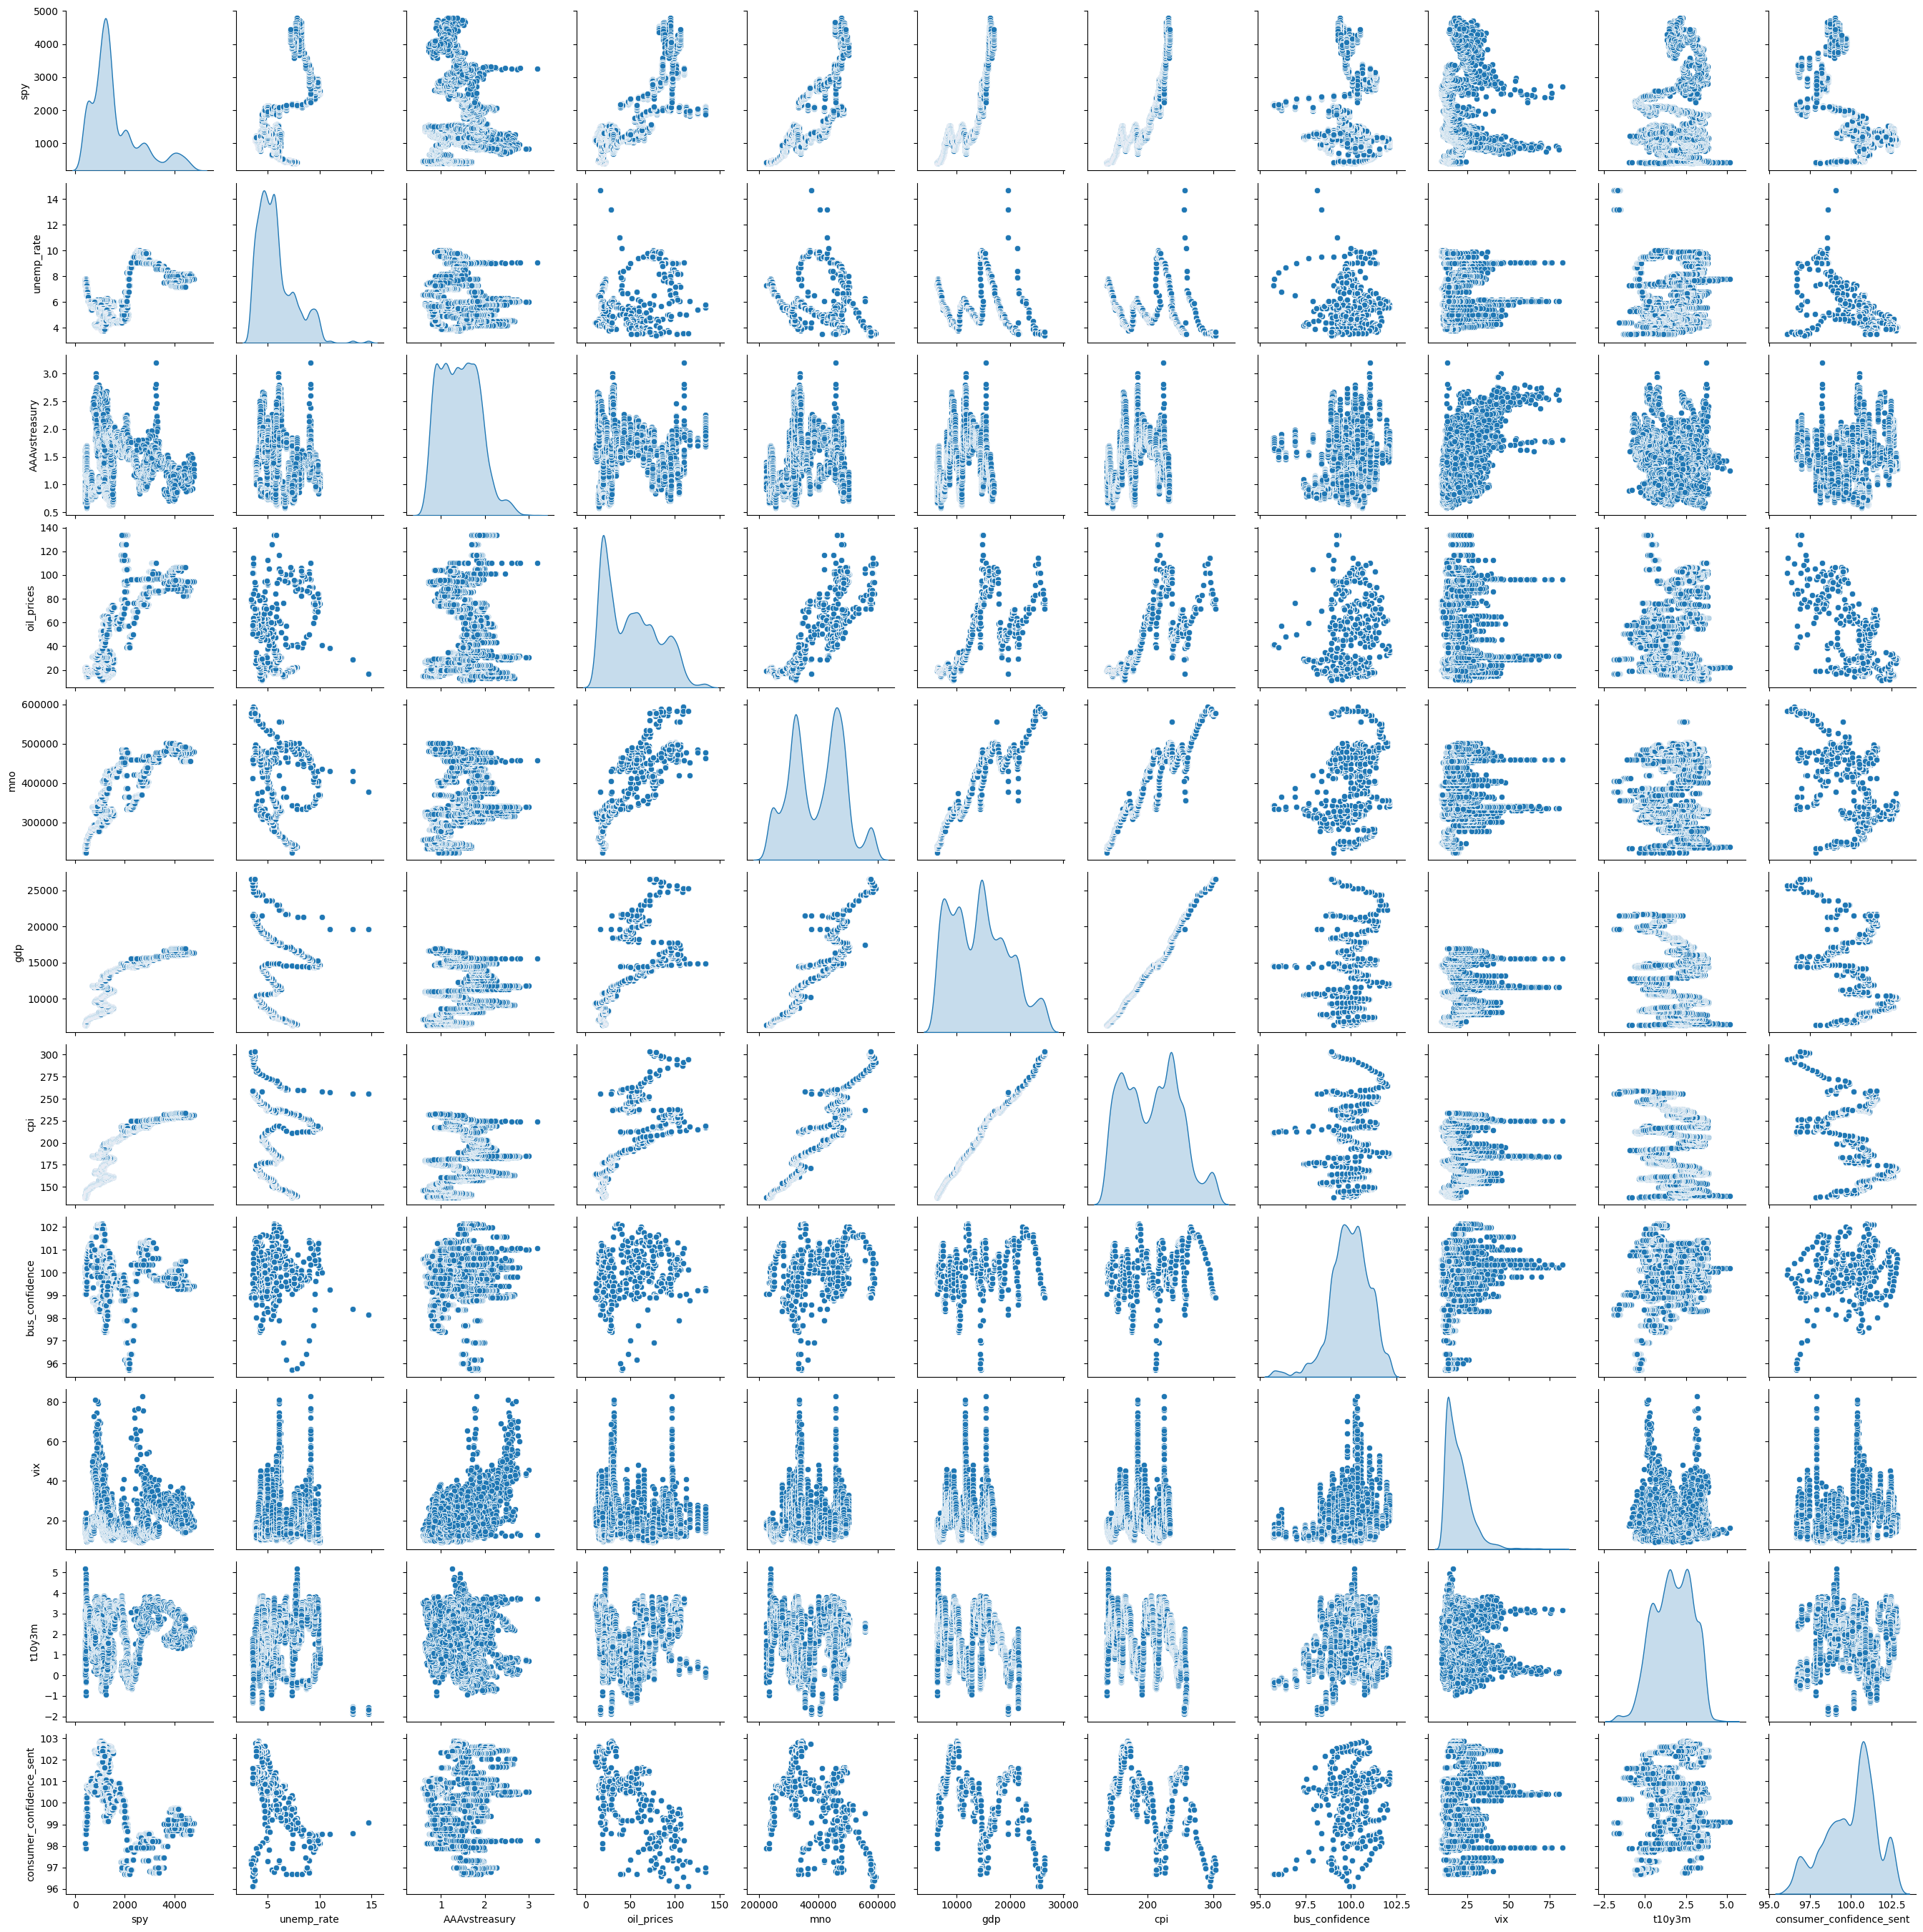

In [123]:
data = pd.concat([
    spy_data['Close'],
    unemp_rate_daily['unemp_rate'],
    aaavstreasury['aaaVsTreasury'],
    oil_prices_daily['oilPrice'],
    mno_daily['manuNewOrders'],
    gdp_daily['GDP'],
    cpi_daily['cpi'],
    bus_confidence_daily['bus_confidence'],
    vix['vix'],
    t10y3m['t10y3m'],
    consumer_confidence_sent_daily['senti']
], axis=1, ignore_index=False)

data.columns = [
    'spy',
    'unemp_rate',
    'AAAvstreasury',
    'oil_prices',
    'mno',
    'gdp',
    'cpi',
    'bus_confidence',
    'vix',
    't10y3m',
    'consumer_confidence_sent'
]


sns.pairplot(data, diag_kind='kde')
plt.show()


In [124]:
data

,spy,unemp_rate,AAAvstreasury,oil_prices,mno,gdp,cpi,bus_confidence,vix,t10y3m,consumer_confidence_sent
0,417.260010,7.3,1.40,18.806957,223500.0,6363.102,138.300,99.043552,18.95,2.32,97.868986
1,419.339996,7.3,1.32,18.806957,223500.0,6363.102,138.300,99.043552,18.75,2.24,97.868986
2,417.959991,7.3,1.33,18.806957,223500.0,6363.102,138.300,99.043552,18.96,2.43,97.868986
3,417.399994,7.3,1.37,18.806957,223500.0,6363.102,138.300,99.043552,19.23,2.46,97.868986
4,418.100006,7.3,1.35,18.806957,223500.0,6363.102,138.300,99.043552,18.72,2.50,97.868986
...,...,...,...,...,...,...,...,...,...,...,...
11499,NaN,3.7,NaN,71.673478,NaN,26529.774,303.294,98.912986,NaN,NaN,96.877280
11500,NaN,3.7,NaN,71.673478,NaN,26529.774,303.294,98.912986,NaN,NaN,96.877280
11501,NaN,3.7,NaN,71.673478,NaN,26529.774,303.294,98.912986,NaN,NaN,96.877280
11502,NaN,3.7,NaN,71.673478,NaN,26529.774,303.294,98.912986,NaN,NaN,96.877280


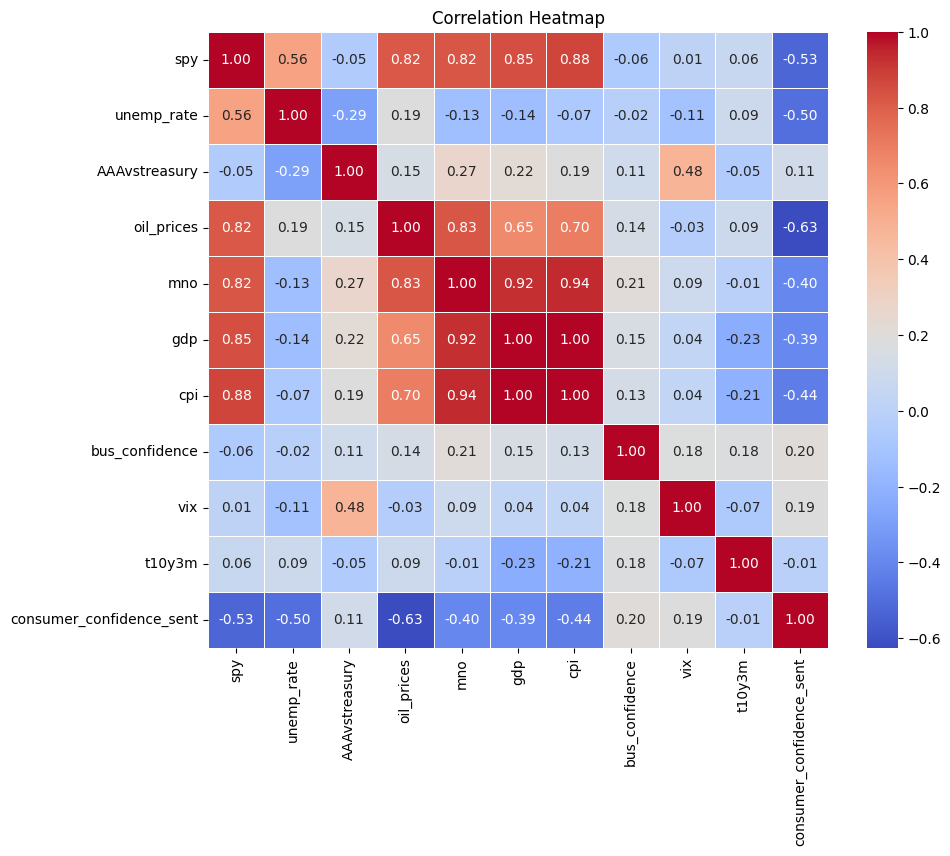

In [125]:
correlation_matrix = data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Use XGBoost to predict SPY using the 10 features

In [126]:
# Prepare the data for training and prediction
data.dropna(inplace=True) # ensure no NaN

X = data.drop('spy', axis=1)  # Features
y = data['spy']  # Target variable



# Split the data into training and test sets with random seed 69 (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)


Mean Squared Error (MSE): 1184.907461538122
Root Mean Squared Error (RMSE): 34.422484825156396
R-squared (R2) Score: 0.9988822689809329


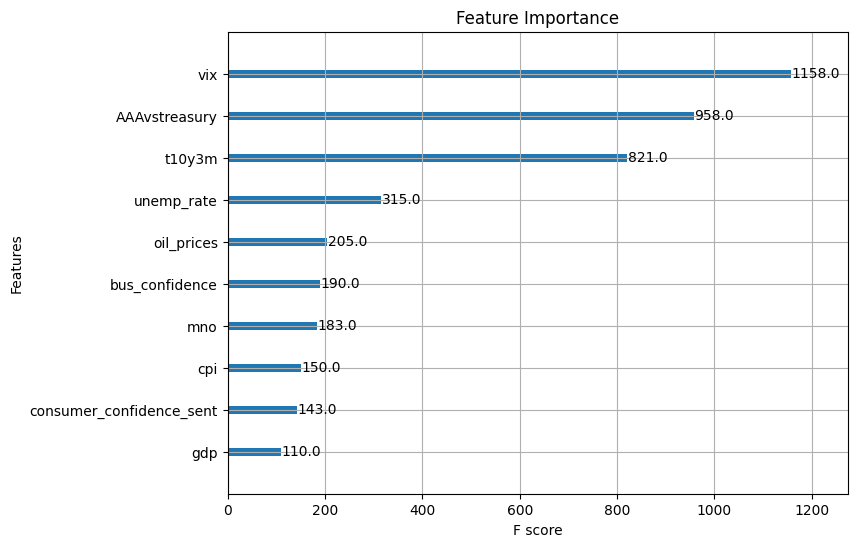

In [127]:
from xgboost import XGBRegressor, plot_importance

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

# Plot importance for each feature
fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(model, ax=ax)
plt.title('Feature Importance')
plt.savefig('figures/xgboost_f_scores', bbox_inches="tight")
plt.show()


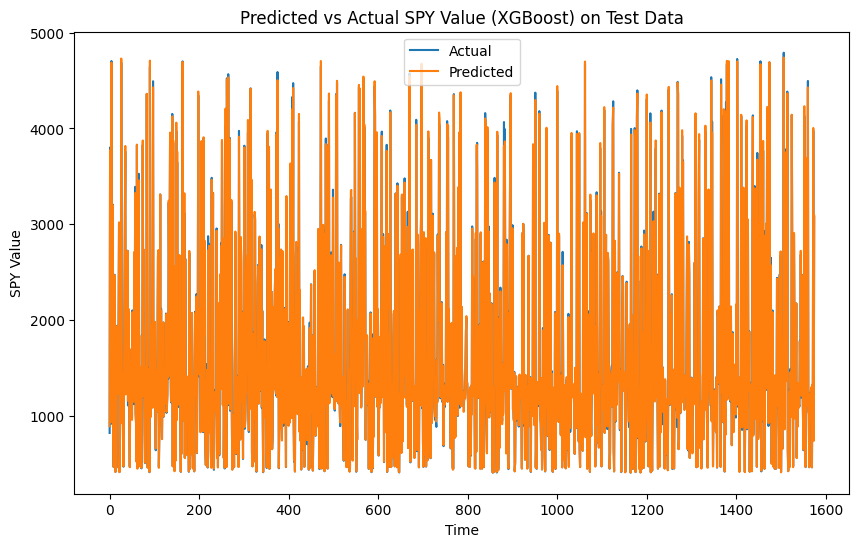

In [128]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

time_index = range(len(y_test))

plt.figure(figsize=(10, 6))
plt.plot(time_index, y_test, label='Actual')
plt.plot(time_index, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SPY Value')
plt.title('Predicted vs Actual SPY Value (XGBoost) on Test Data')
plt.legend()
plt.savefig('figures/predictedvsSPY_Testdata.png', bbox_inches="tight")
plt.show()


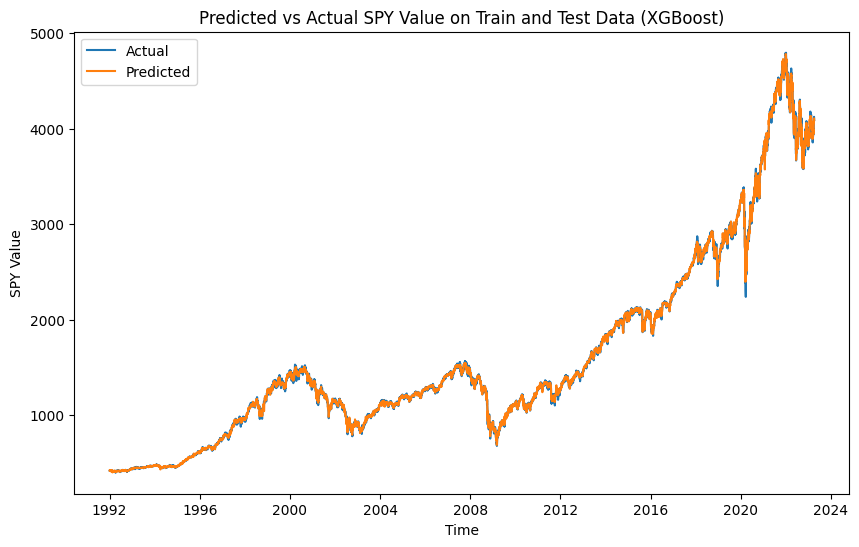

In [129]:
# Make predictions on all the data prior to splitting
y_pred = model.predict(X)

# Create a time index for plotting
time_index = range(len(y_pred))

# Get the dates from the 'spy_data' dataframe based on the index numbers for alignment
dates = spy_data['Date'].iloc[time_index]

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(dates, y, label='Actual')
plt.plot(dates, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SPY Value')
plt.title('Predicted vs Actual SPY Value on Train and Test Data (XGBoost)') 
plt.legend()
plt.savefig('figures/predictedvsSPY_inclTrain.png', bbox_inches="tight", dpi=300)
plt.show()
